# Twitter Bot Classification

## User Based Classification

Classification techniques based on features like favorite count, reply count, retweet count, age of the twitter account etc.

In [1]:
import pandas as pd
df_train = pd.read_csv('training.csv')
df_train.rename(columns = {'favourites_count': 'favorites_count'}, inplace = True)

### Data pre-processing and splitting data into training and testing sets

In [2]:
import numpy as np

def get_data(frame):
    new_frame = pd.DataFrame()
    l = ['followers_count', 'friends_count', 'listed_count', 'favorites_count', 'statuses_count', 'bot']
    l1 = ['followers', 'friends', 'listed', 'favorite', 'statuses', 'bot']
    for i, j in zip(l, l1):
        new_frame[j] = pd.Series(frame[i].astype(float))
        new_frame.fillna(np.mean(new_frame[j]), inplace = True)
    return new_frame
df = get_data(df_train)
df.bot = df.bot.astype(int)
x, y = df.iloc[:, 0:-1].values, df.bot.values

In [3]:
from sklearn.model_selection import train_test_split as tts
x_train, x_test, y_train, y_test = tts(x, y, test_size=0.2, random_state=42)

### Decision Tree Classifier(CART)

In [4]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)

In [5]:
from sklearn.metrics import accuracy_score as acc, precision_score as prec
from sklearn.metrics import confusion_matrix, recall_score as rec

def metrics_calc(y_test, y_pred):
    con_mat = confusion_matrix(y_test, y_pred)
    print('Precision = ', prec(y_test, y_pred))
    print('Recall = ', rec(y_test, y_pred))
    print('Accuracy = ', acc(y_test, y_pred))
    return con_mat

y_pred = clf.predict(x_test)
con_mat = metrics_calc(y_test, y_pred)
con_mat

Precision =  0.832089552238806
Recall =  0.825925925925926
Accuracy =  0.8357142857142857


array([[245,  45],
       [ 47, 223]], dtype=int64)

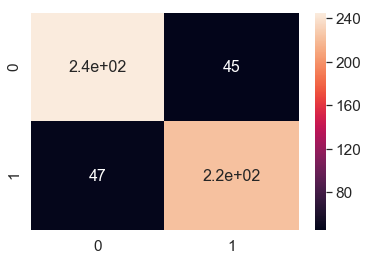

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def plot(con):
    df_cm = pd.DataFrame(con, range(2), range(2))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})
plot(con_mat)

### Random Forest Classifier

In [7]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 10, max_depth = 2, random_state=0,
                                bootstrap = True, criterion = 'entropy')

In [8]:
clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [9]:
y_pred = clf.predict(x_test)
con_mat = metrics_calc(y_test, y_pred)

Precision =  0.8918918918918919
Recall =  0.7333333333333333
Accuracy =  0.8285714285714286


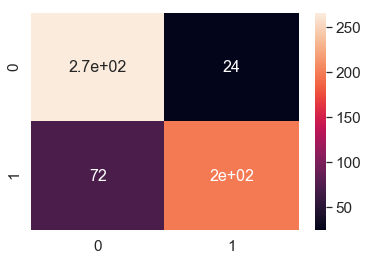

In [10]:
plot(con_mat)

### Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', penalty = 'l2')
clf.fit(x_train, y_train)
clf.intercept_, clf.coef_, clf.score(x_test, y_test)

(array([2.79901339e-07]),
 array([[-1.51741996e-07,  9.63471291e-07, -4.61505929e-04,
         -3.09294270e-05,  1.28972920e-05]]),
 0.7035714285714286)

In [12]:
y_pred = clf.predict(x_test)
con_mat = metrics_calc(y_pred, y_test)

Precision =  0.6555555555555556
Recall =  0.708
Accuracy =  0.7035714285714286


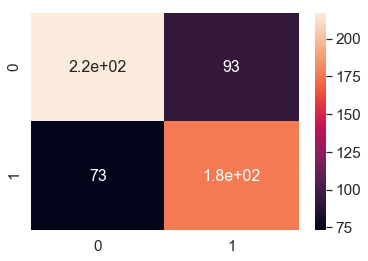

In [13]:

plot(con_mat)

## Tweet Based Classification

Classification technique based on the features(or words) that can be obtained from the text written in a tweet.

In [14]:
docs = df_train.description.dropna().tolist()
vals = df_train.bot.tolist()

### Cleaning the text in tweets

In [15]:
import re, string
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english')) 
for i in range(len(docs)):
    docs[i] = docs[i].lower()
    docs[i] = docs[i].translate(docs[i].maketrans('', '', '"'))
    docs[i] = re.sub(r'^https?:\/\/.*[\r\n]*', '', docs[i], flags=re.MULTILINE)
    docs[i] = docs[i].translate(docs[i].maketrans('', '', string.punctuation))
    docs[i] = ' '.join([re.sub("\d+", " ", j) for j in word_tokenize(docs[i]) if j not in stop_words and 'https' not in j])

isvalid = lambda x: 48 <= ord(x) <= 57 or 97 <= ord(x) <= 122 or ord(x) == 32
for i in range(len(docs)):
    k = list(docs[i])
    for j in range(len(k)):
        k[j] = k[j] if isvalid(k[j]) else ''
    docs[i] = ''.join(k)

### Naive Bayes Classifier

In [16]:
all_words = set()
for i in docs:
    all_words = all_words.union(set(i.split()))

In [17]:
train = list()
d = dict(zip(list(all_words), [False for _ in range(len(all_words))]))
for i in range(len(docs)):
    f = d.copy()
    for j in word_tokenize(docs[i]):
        f[j] = True
    train.append((f, vals[i]))
len(train)

2394

In [18]:
from random import shuffle
shuffle(train)
train, test = train[:1915], train[1915:]

In [19]:
cls = nltk.NaiveBayesClassifier.train(train)

In [20]:
nltk.classify.accuracy(cls, test)

0.778705636743215